In [431]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')
import random
from datetime import datetime, timedelta
from dateutil.rrule import rrule, WEEKLY, FR, SU

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import get_candles
from indicator.trend import ExponentialMovingAverage
from notebooks.compute_indicators import moyenne_mobile_features
from utils.utils import compute_sign_changement
from notebooks.display_indicators import show_candle, add_indicator
from indicator.trend import BollingerBands, Slope
from indicator.oscillator import Atr, Obv
from indicator.trend import ExponentialMovingAverage, MovingAverage

# Get data

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

In [432]:
start_date = '2019-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

In [1]:
candles.head()

NameError: name 'candles' is not defined

# Compute indicator

In [560]:
table = 'candle1h'
symbol = 'EUR/USD'

candles_to_show = candles[(candles['table'] == table) & (candles['symbol'] == symbol)]

In [561]:
bb = BollingerBands(candles_to_show)
candles_to_show['ma'], candles_to_show['bb_up'], candles_to_show['bb_down'] = bb.compute(span=20, nb_std=2)

In [562]:
atr = Atr(candles_to_show)
candles_to_show['atr'], _ = atr.compute(span=6, avg_type='ewm')

In [563]:
obv = Obv(candles_to_show)
candles_to_show['obv'] = obv.compute()
candles_to_show['obv_perc_1'] = 100 * candles_to_show['obv'].pct_change()
candles_to_show['obv_perc_2'] = 100 * candles_to_show['obv'].pct_change(2)
candles_to_show['tickqty_pct_1'] = 100 * candles_to_show['tickqty'].pct_change()
candles_to_show['tickqty_pct_2'] = 100 * candles_to_show['tickqty'].pct_change(2)

In [564]:
ma = MovingAverage(candles_to_show)
candles_to_show['ma_200'] = ma.compute(span=200)

ma = MovingAverage(candles_to_show)
candles_to_show['ma_100'] = ma.compute(span=100)


ma = MovingAverage(candles_to_show)
candles_to_show['ma_40'] = ma.compute(span=40)

ema = ExponentialMovingAverage(candles_to_show)
candles_to_show['ema_20'] = ema.compute(span=20)

In [565]:
candles_to_show.dropna(inplace=True, axis=0)

In [566]:
candles_to_show.head()

table                date   symbol     open    close      low  \
1828509  candle1h 2019-01-14 06:00:00  EUR/USD  1.14792  1.14751  1.14696   
1828510  candle1h 2019-01-14 07:00:00  EUR/USD  1.14751  1.14804  1.14552   
1828511  candle1h 2019-01-14 08:00:00  EUR/USD  1.14804  1.14757  1.14658   
1828512  candle1h 2019-01-14 09:00:00  EUR/USD  1.14757  1.14632  1.14615   
1828513  candle1h 2019-01-14 10:00:00  EUR/USD  1.14632  1.14626  1.14513   

            high  tickqty        ma     bb_up  ...       atr    obv  \
1828509  1.14811     5474  1.146959  1.148579  ...  0.000927   3091   
1828510  1.14819    20877  1.147009  1.148699  ...  0.001425  23968   
1828511  1.14828    20807  1.146996  1.148664  ...  0.001504   3161   
1828512  1.14806    19037  1.146918  1.148556  ...  0.001620 -15876   
1828513  1.14666    18395  1.146815  1.148336  ...  0.001594 -34271   

         obv_perc_1   obv_perc_2  tickqty_pct_1  tickqty_pct_2    ma_200  \
1828509  -63.911267   -31.931293      36.033797      98.621190  1.144991   
1828510  675.412488   179.836544     281.384728     418.812127  1.144992   
1828511  -86.811582     2.264639      -0.335297     280.105955  1.144986   
1828512 -602.246125  -166.238318      -8.506753      -8.813527  1.144979   
1828513  115.866717 -1184.182221      -3.372380     -11.592253  1.144986   

           ma_100     ma_40    ema_20  
1828509  1.149290  1.149397  1.147747  
1828510  1.149323  1.149351  1.147775  
1828511  1.149354  1.149289  1.147756  
1828512  1.149368  1.149200  1.147619  
1828513  1.149378  1.149105  1.147490  

[5 rows x 21 columns]

In [567]:
#sl = Slope(candles_to_show, col='ma')
#candles_to_show['ma_slope'] = sl.compute(span=5)

In [569]:
candles_to_show['range_bb'] = candles_to_show['bb_up'] - candles_to_show['bb_down'] 
candles_to_show['range_bb_pct'] = 100 * candles_to_show['range_bb'].pct_change()
candles_to_show['range_bb_pct_3'] = 100 * candles_to_show['range_bb'].pct_change(3)
candles_to_show['log_range_bb'] = np.log(candles_to_show['range_bb'])
candles_to_show['log_atr'] = np.log(candles_to_show['atr'])

In [576]:
res = list()
previous = list()
nb_previous = 10
candles_to_show.reset_index(inplace=True, drop=True)
for row in candles_to_show.itertuples():
    if row.Index < nb_previous:
        res.append(np.NaN)
        previous.append(row)
        continue

    #if (previous[2].range_bb_pct < 0 and previous[1].range_bb_pct < 0 and previous[0].range_bb_pct < 0) \
    #    and (row.range_bb_pct > previous[3].range_bb_pct > 0) \
    #    and row.range_bb > abs(1.5 * previous[2].range_bb):
    
    #if row.range_bb > abs(1.3 * previous[3].range_bb) and row.range_bb > abs(1.3 * previous[2].range_bb) \
    #and ((row.low > row.ma and row.close > row.open) or (row.high < row.ma and row.close < row.open)):
    
    #if row.high > row.bb_up or row.low < row.bb_down:
    #if row.low > row.bb_up and row.close - row.open < 0 :#and (row.high - (row.high - row.low) * 0.9) > row.close :
    #if (row.close > row.bb_up and row.open < row.bb_up) or (row.close < row.bb_down and row.open > row.bb_down):
    if row.high > row.bb_down and row.low < row.bb_down \
        and (row.high - row.low) < row.range_bb / 3 and abs(row.close - row.open) > 0.5 * (row.high - row.low):
        #and row.tickqty_pct_1 > 0 and row.tickqty_pct_1 < 1000 and row.tickqty_pct_2 > 0 and row.tickqty_pct_1 > previous[nb_previous - 1].tickqty_pct_1 \
        #and all([x.close > x.ma for x in previous[:5]]) \
        #and row.close < row.open
        #and not any([x.high < x.ma for x in previous]) 
        #and all([x.close > x.ma_40 for x in previous]) \
        res.append(1)
        
    else:
        res.append(0)
    del previous[0]
    previous.append(row)
    

In [577]:
candles_to_show['res'] = res
candles_to_show[candles_to_show['res'] == 1].shape

(231, 28)

In [578]:
candles_to_show['sum_res'] = candles_to_show['res'].rolling(2).sum()

In [579]:
candles_to_show[candles_to_show['date'] == '2020-06-22 09:00:00']

table                date   symbol     open    close      low  \
9113  candle1h 2020-06-22 09:00:00  EUR/USD  1.12251  1.12142  1.12126   

         high  tickqty        ma     bb_up  ...    ma_100     ma_40    ema_20  \
9113  1.12273    18835  1.119272  1.121721  ...  1.123132  1.120153  1.119991   

      range_bb  range_bb_pct  range_bb_pct_3  log_range_bb   log_atr  res  \
9113  0.004899      9.649478        32.53157     -5.318717 -6.428228  0.0   

      sum_res  
9113      0.0  

[1 rows x 28 columns]

In [580]:
def show_random_cases(candles, indicator, nb_examples_to_show=30, nb_candles_to_show=50):
    idx = candles.index.tolist()
    #idx = candles[(candles['log_range_bb'] > -5.5) & (candles['log_range_bb'] < -5)].index.tolist()
    #idx = candles[(candles['sum_res'] == 1) & (candles['res'] == 1) & ((candles['tickqty_pct_1'] > 100) | (candles['tickqty_pct_2'] > 100))].index.tolist()
    idx = candles[(candles['sum_res'] == 1) & (candles['res'] == 1)].index.tolist()
    #idx = candles[candles['atr'] < candles['range_bb'] / 4].index.tolist()
    print(len(idx))
    random.shuffle(idx)

    idx_to_show = idx[:nb_examples_to_show]
    #idx_to_show = [921280, 921280]

    range_of_idx_to_show = [(x - nb_candles_to_show // 2, x + nb_candles_to_show // 2) for x in idx_to_show]
    
    for i, (idx_start, idx_end) in enumerate(range_of_idx_to_show):
        data = candles.loc[idx_start: idx_end, :]
        idx = nb_candles_to_show // 2 + idx_start
            
        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)
        #print(range_of_idx_to_show[i])
        #print(str(candles.loc[idx_to_show[i], ['date', 'atr', 'range_bb']]))
        #print(str(candles.loc[idx_to_show[i], 'range_bb'] / candles.loc[idx_to_show[i], 'atr']))
        print(candles.loc[idx_to_show[i], 'tickqty_pct_1'])
        print(candles.loc[idx_to_show[i], 'tickqty_pct_2'])
        print("***********")

        width = 2
        color = 'rgba(46, 134, 193, 0.5)'
        fig.add_trace(go.Candlestick(x=data['date'],
                                     open=data['open'],
                                     high=data['high'],
                                     low=data['low'],
                                     close=data['close']),
                      row=1, col= i % 2 + 1)
        

        fig.add_trace(go.Scatter(x=data['date'],
                                 y=data['bb_up'],
                                 mode='lines',
                                 name='bollinger_up',
                                 line=dict(color=color, width=width)
                                 ),
                      row=1, col= i % 2 + 1
                      )
        fig.add_trace(go.Scatter(x=data['date'],
                                 y=data['bb_down'],
                                 mode='lines',
                                 name='bollinger',
                                 line=dict(color=color, width=width)

                                 ),
                      row=1, col= i % 2 + 1
                      )
        fig.add_trace(go.Scatter(x=data['date'],
                                 y=data['ma'],
                                 mode='lines',
                                 name='bollinger_dow',
                                 line=dict(color=color, width=width)

                                 ),
                      row=1, col= i % 2 + 1
                      )
        fig.add_vline(x=str(candles.loc[idx_to_show[i], 'date']), line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)


        if i % 2 == 1:
            fig.show()

183
112.72727272727275
260.0
***********
8.632269279393178
29.94187420254242
***********


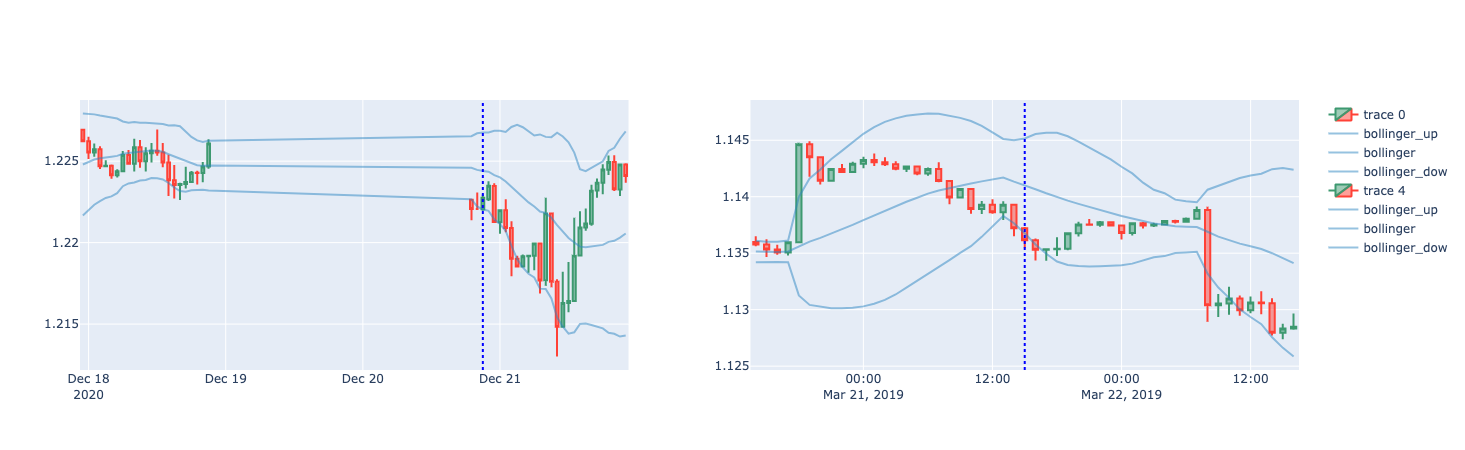

-34.3579766536965
2.865853658536577
***********
26.11791730474733
103.22023442319556
***********


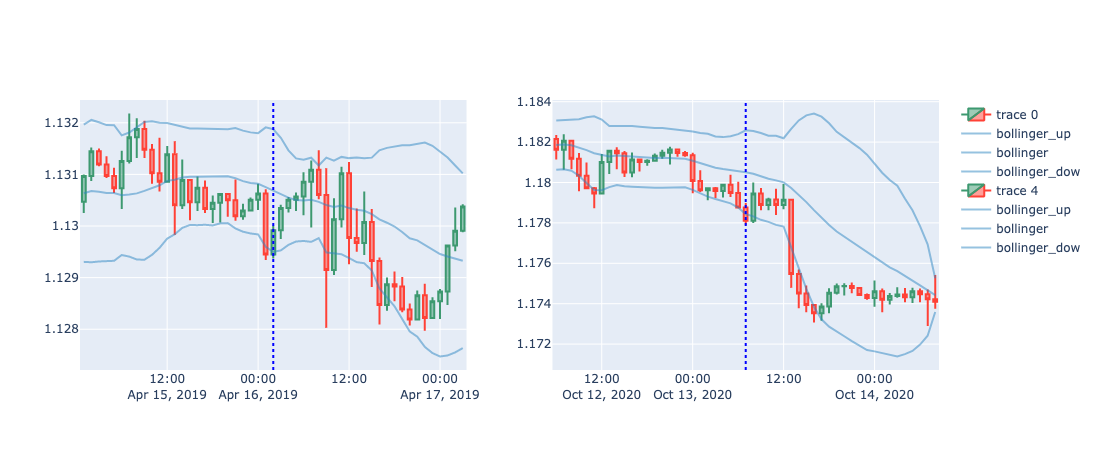

72.66844309097831
35.00000000000001
***********
-57.0542562257362
-72.40340736233648
***********


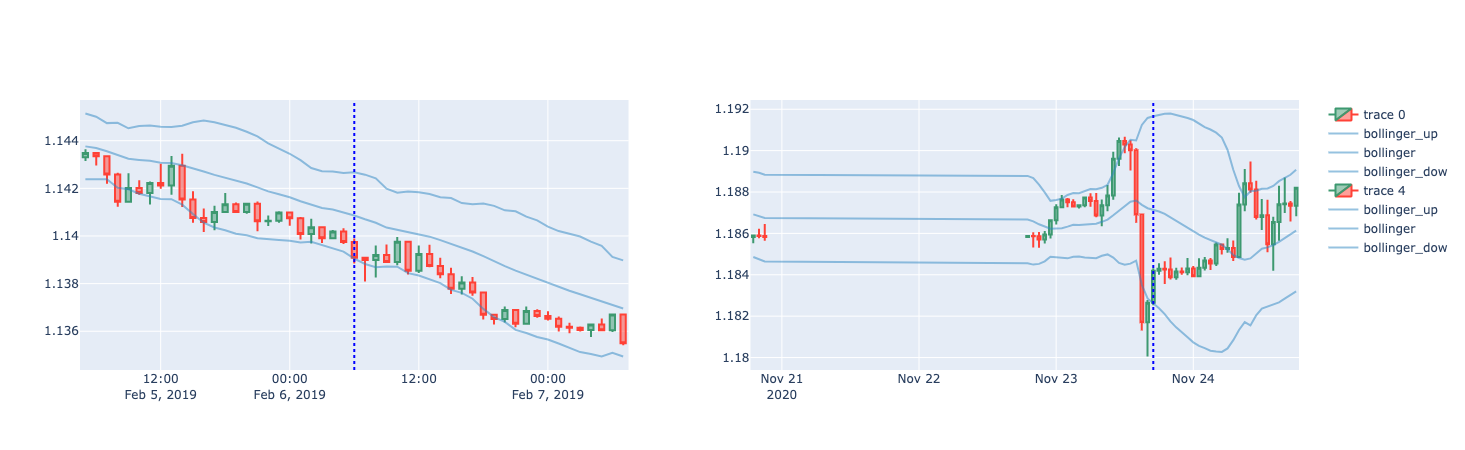

-3.3945221445221496
70.20020533880904
***********
12.797724848915749
-17.98914448177824
***********


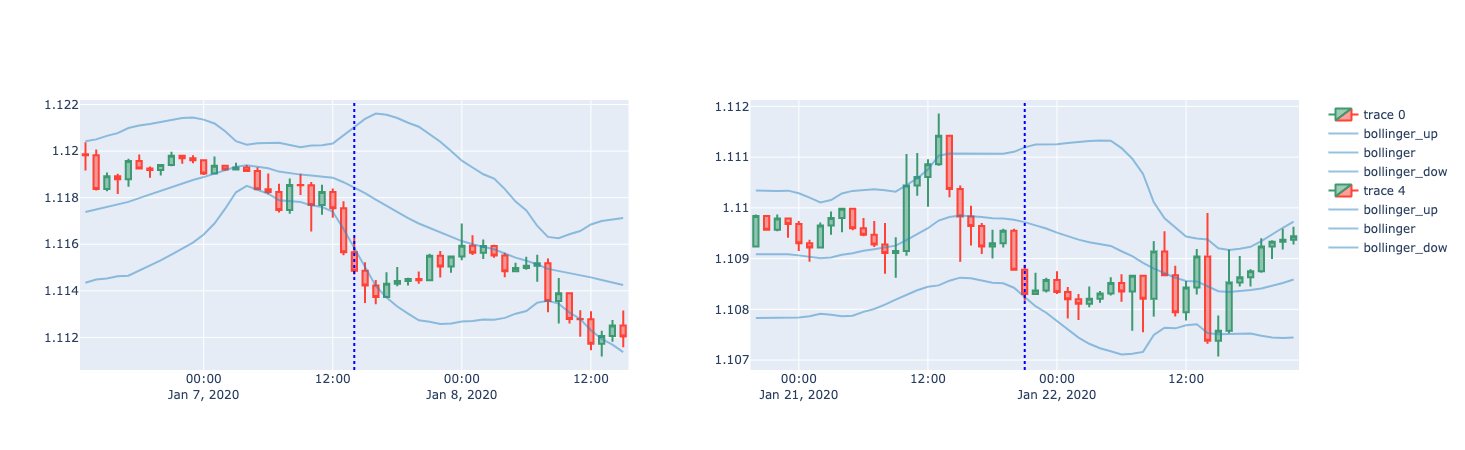

-51.232886043185076
-26.164079822616404
***********
-6.203228400024741
-4.553321375751285
***********


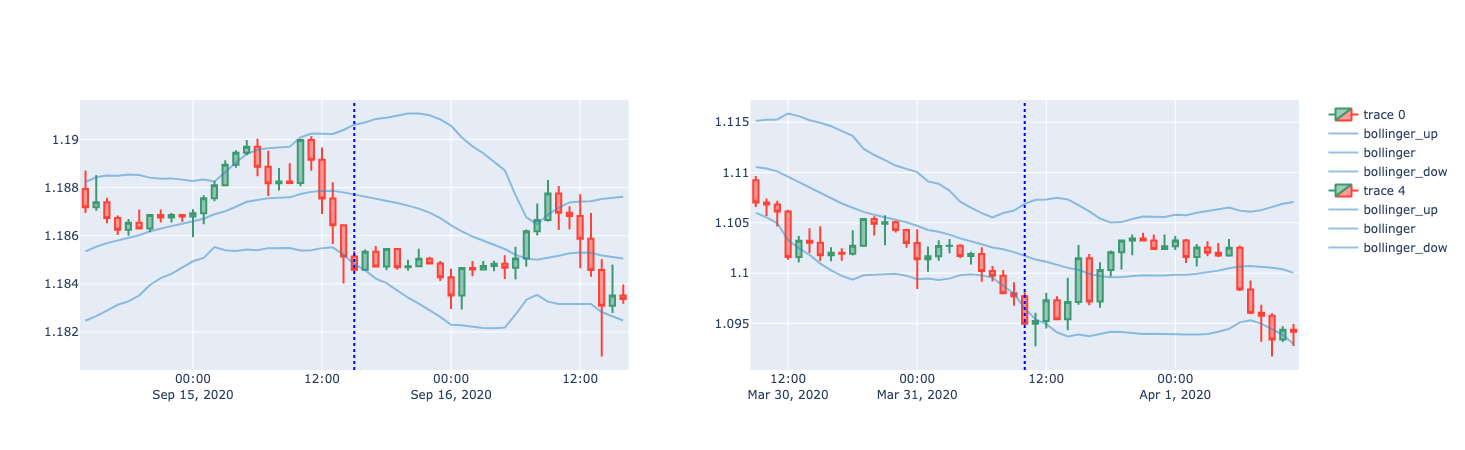

-36.6098869615044
-39.2066743268222
***********
-15.832263585793749
23.574681953824417
***********


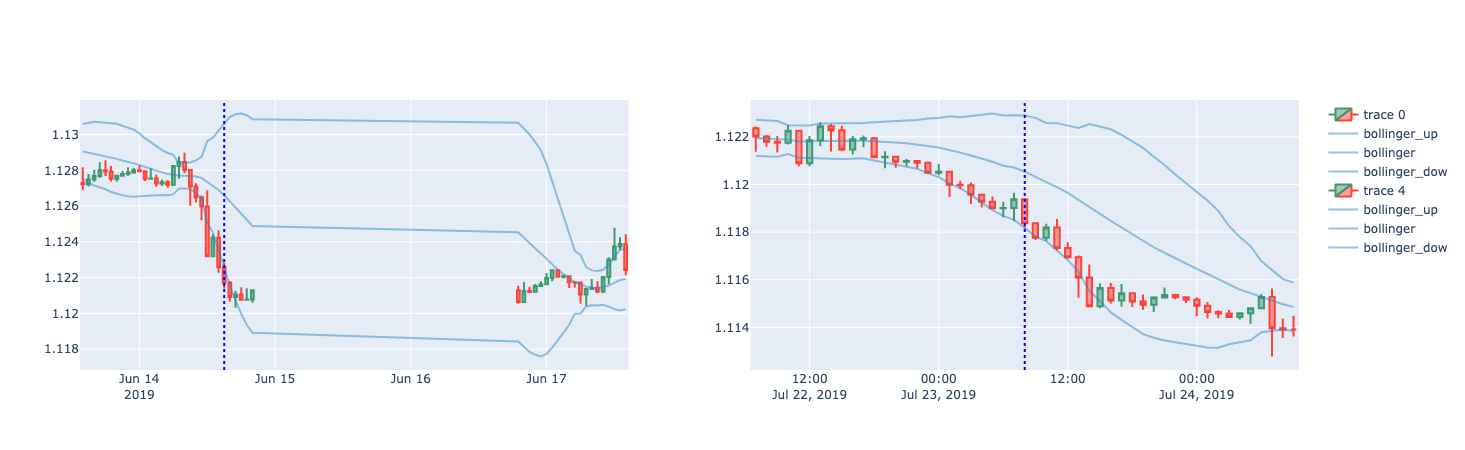

-6.7338516172377405
-32.337622549019606
***********
-45.196582383995555
-62.68063669260424
***********


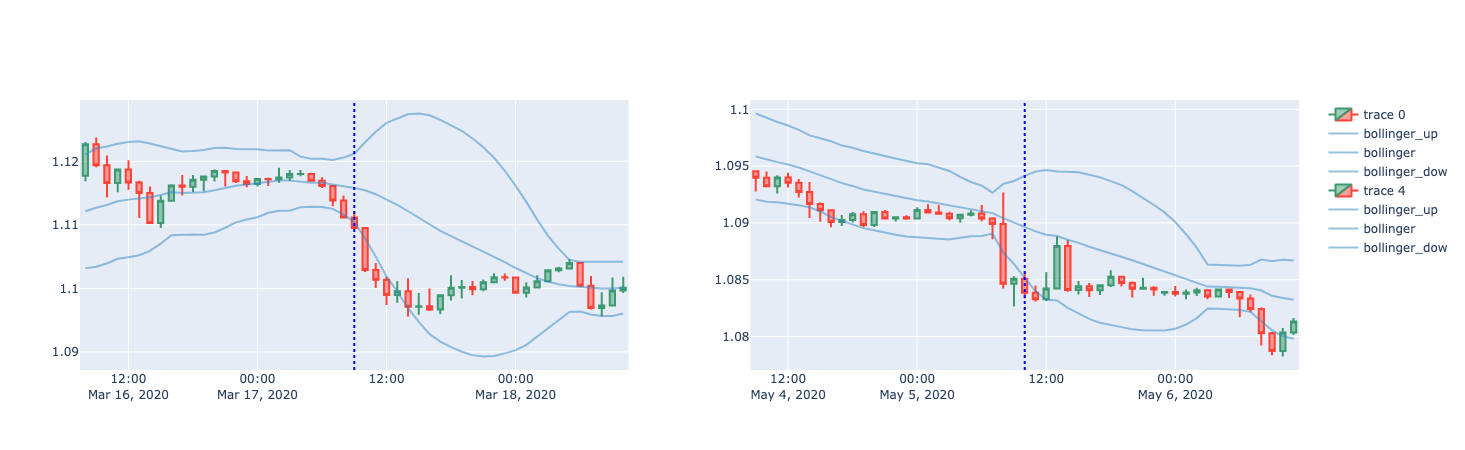

-7.4859747545582
53.31202789076119
***********
20.74042000432994
-7.860063607451162
***********


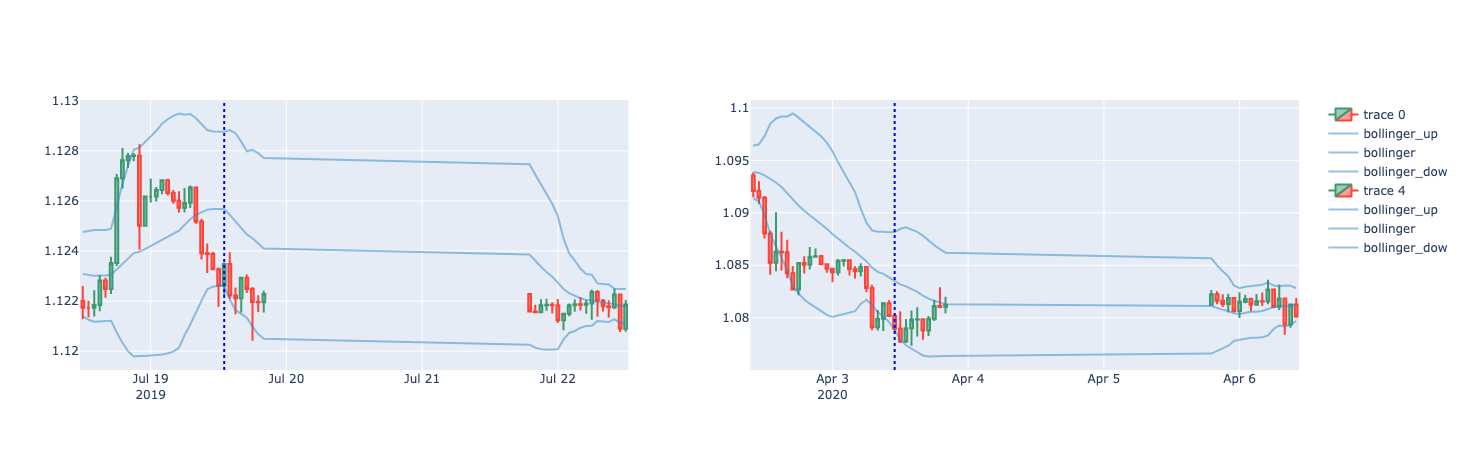

-19.692501087849923
-34.41263573543929
***********
-8.529496196354236
22.042418729353198
***********


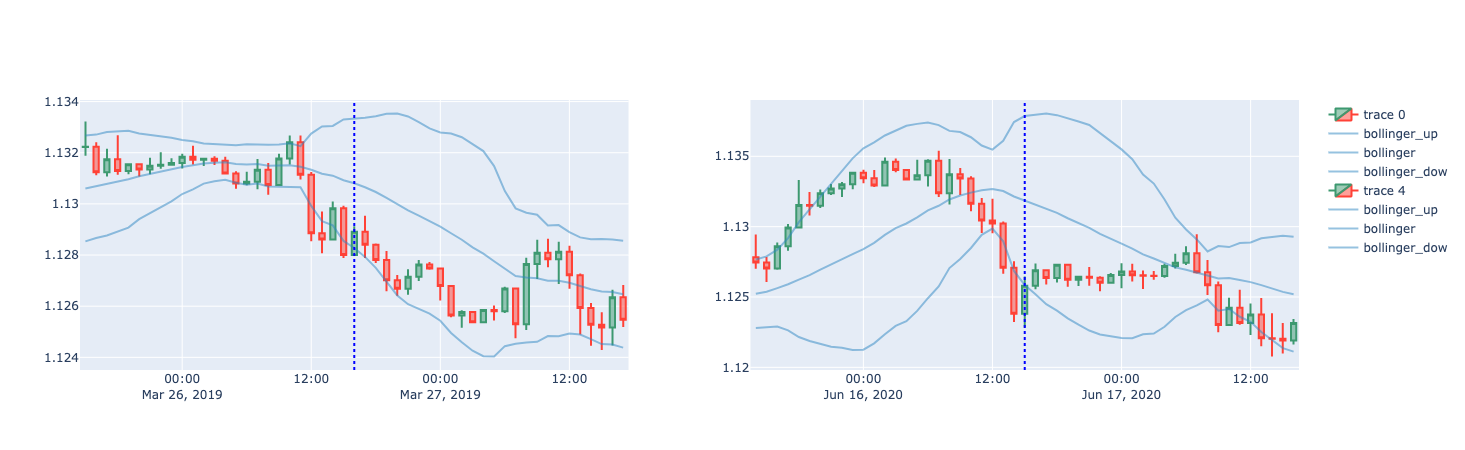

-4.9857179953258886
-25.50390227349847
***********
15.820917008565472
39.10525178301276
***********


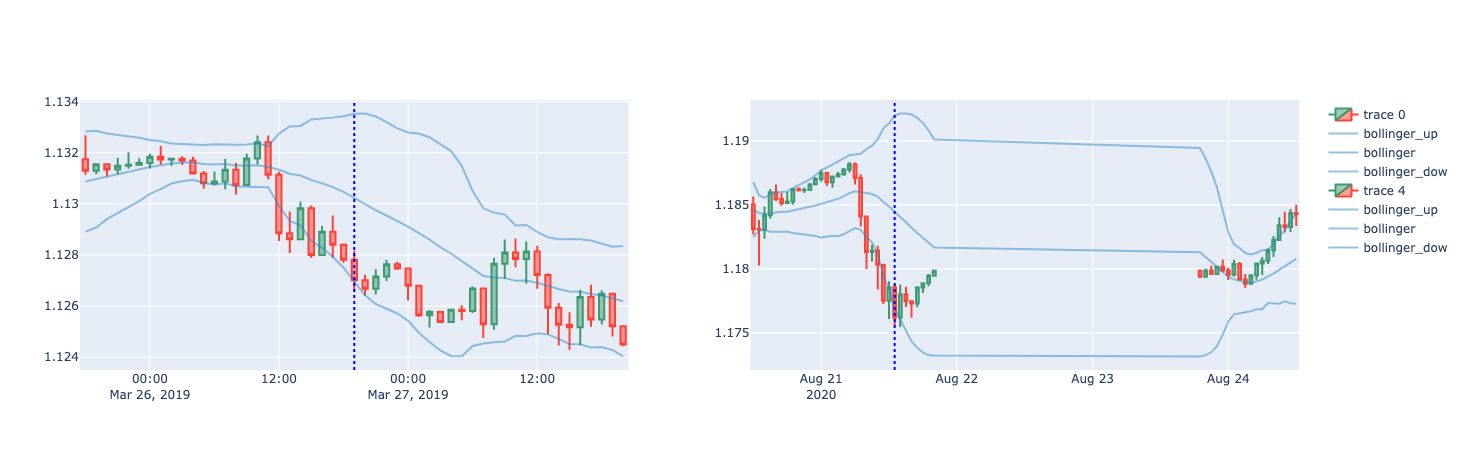

42.47903643848148
78.08521991005412
***********
83.4259053543657
-8.42607313195548
***********


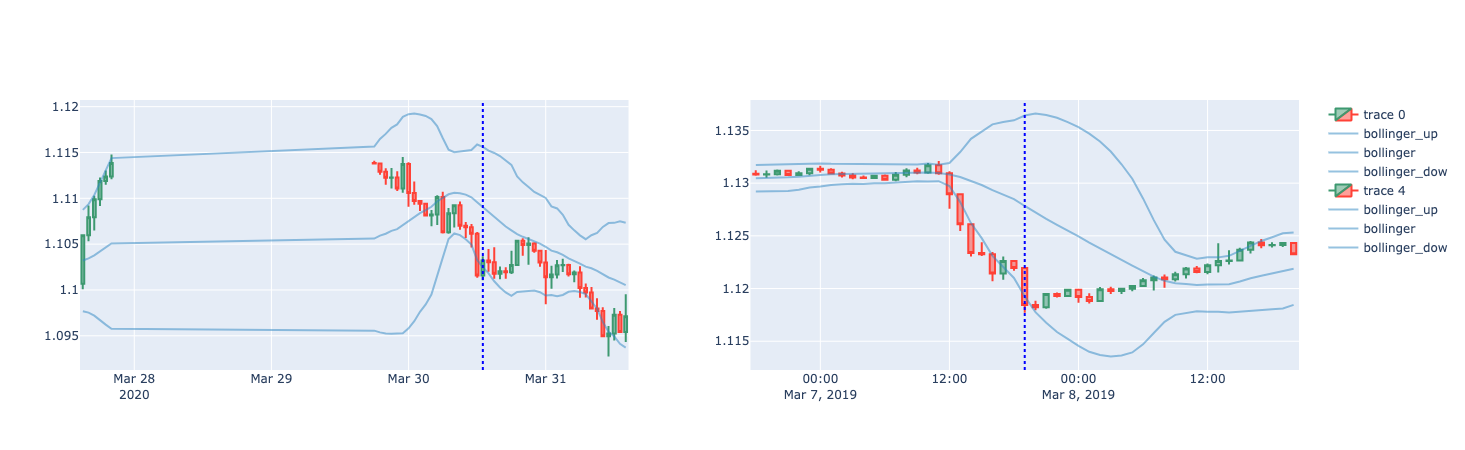

-24.267211997273353
-48.58564239023544
***********
-3.1005221932114857
17.630744849445335
***********


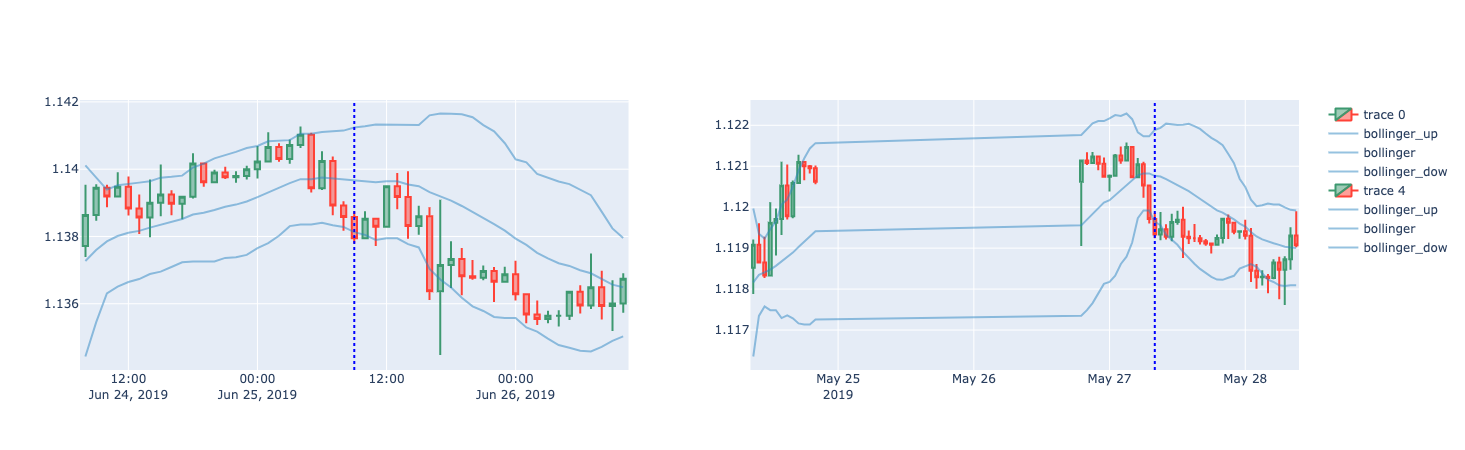

-30.629215559456714
-60.89786990260924
***********
-46.42671382502861
-57.55028025057698
***********


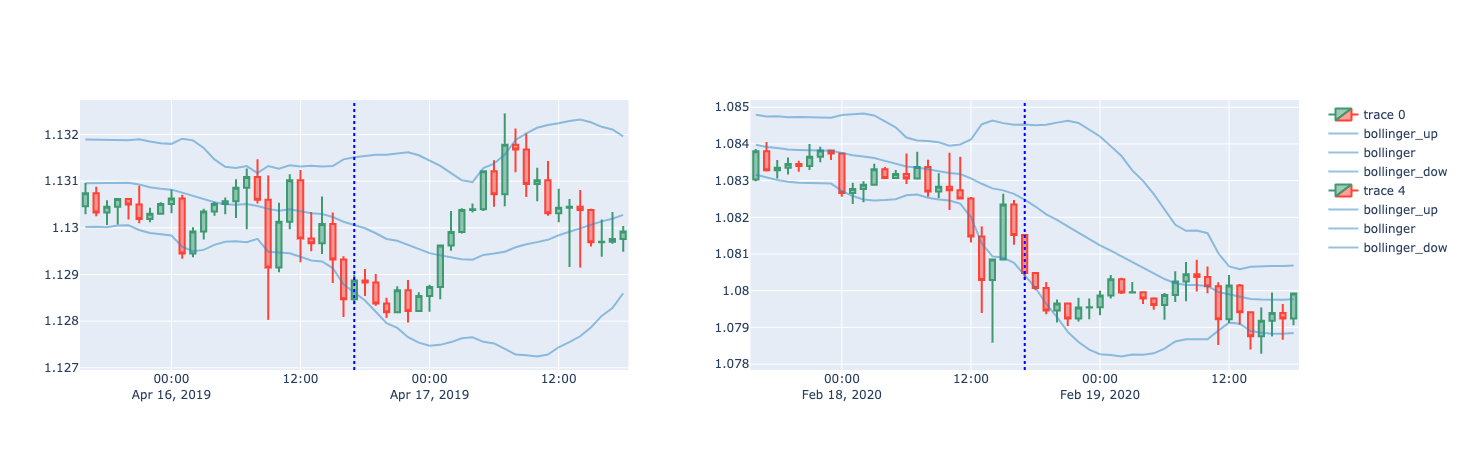

6.299393493843053
28.950448692937968
***********
-35.515104570100696
-6.983240223463683
***********


In [ ]:
show_random_cases(candles_to_show, bb)

# Show data
## Full graph

In [7]:
candles_to_show.head()

table                date   symbol     open    close      low  \
1910806  candle4h 2019-01-02 04:00:00  EUR/USD  1.14459  1.14775  1.14459   
1910807  candle4h 2019-01-02 08:00:00  EUR/USD  1.14775  1.14345  1.14228   
1910808  candle4h 2019-01-02 12:00:00  EUR/USD  1.14345  1.13546  1.13426   
1910809  candle4h 2019-01-02 16:00:00  EUR/USD  1.13546  1.13444  1.13258   
1910810  candle4h 2019-01-02 20:00:00  EUR/USD  1.13444  1.13134  1.13103   

            high  tickqty  ema8      ema5  ema5_minus_ema8  \
1910806  1.14975    33013   NaN       NaN              NaN   
1910807  1.14788    94684   NaN       NaN              NaN   
1910808  1.14348   123076   NaN       NaN              NaN   
1910809  1.13629    72031   NaN       NaN              NaN   
1910810  1.13648    49071   NaN  1.135458              NaN   

         ema5_minus_ema8_pos  ema5_minus_ema8_neg  
1910806                    0                    0  
1910807                    0                    0  
1910808                    0                    0  
1910809                    0                    0  
1910810                    0                    0

In [18]:
strat = MacdStrat(candles_to_show, 1)
strat.apply_strategy(1e-5)

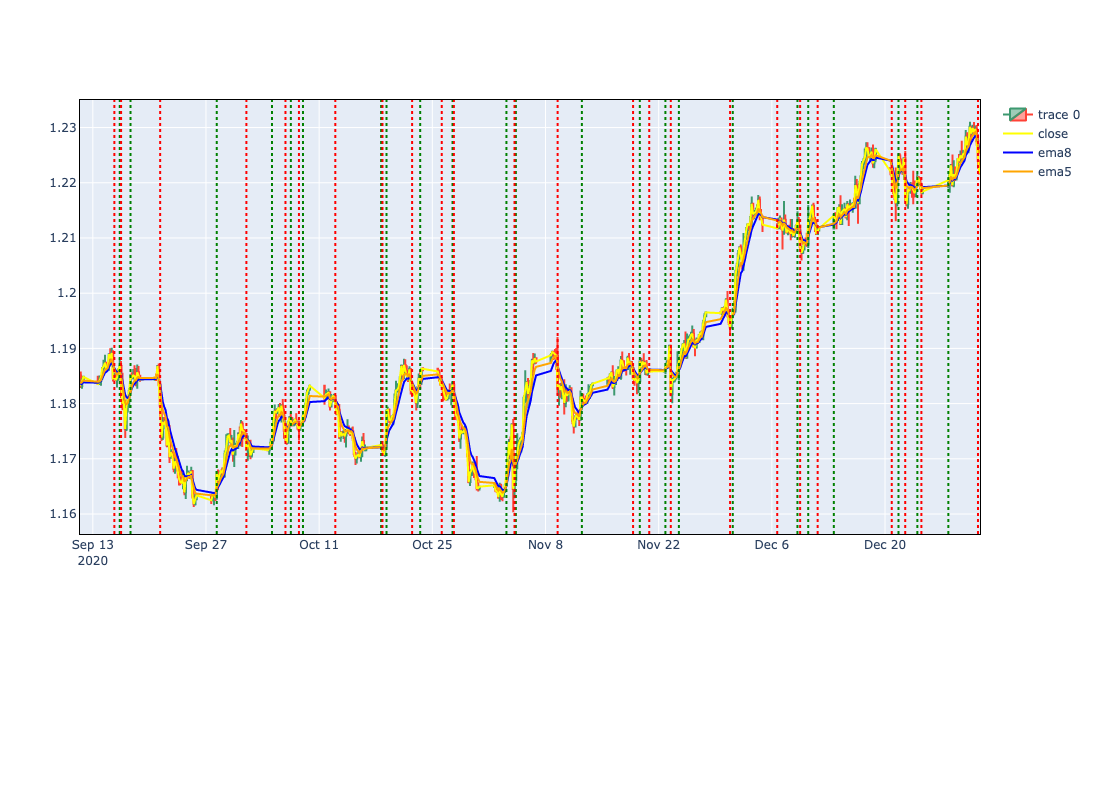

In [27]:
data = cMacdStratdles_to_show.tail(500)
fig = show_candle(data, size=(1000, 800))

fig = add_indicator(data[['date', 'close']], fig, 'close', color='yellow')

for indicator_name, color in  [('ema8', 'blue'), ('ema5', 'orange')]:
    fig = add_indicator(data[['date', indicator_name]], fig, indicator_name, color=color)

for indicator_name, color in [('ema5_minus_ema8_pos', 'green'), ('ema5_minus_ema8_neg', 'red')]:
    data_tmp = data[data[indicator_name] == 1]
    for row in data_tmp.itertuples():
        fig.add_vline(x=row.date, line_dash='dot', line_color=color)

fig.show()

## Exemples

In [26]:
indicator_name = 'action'
nb_examples_to_show = 30
nb_candles_to_show = 100
candles_to_show = strat.data
possible_idx = candles_to_show[candles_to_show[indicator_name].isin([-1, 1])].index.tolist()
random.shuffle(possible_idx)
idx_to_show = possible_idx[:nb_examples_to_show]

In [27]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np

span = 5
slopes = list()

def compute_slope(candles, idx, span=5, before=True):
    if before:
        y = candles.loc[idx - span + 1:idx, ['close']]
    else:
        y = candles.loc[idx: idx + span - 1, ['close']]
    x = np.arange(span).reshape((span, 1))
    y_scaled = (y - y.min()) / (y.max() - y.min())
    if len(y_scaled[y_scaled.isnull().any(axis=1)]):
        return 0
    x_scaled = (x - x.min()) / (x.max() - x.min())
    lr = LinearRegression()
    try:
        lr.fit(x_scaled, y_scaled)
    except:
        return 0
    return np.rad2deg(np.arctan(lr.coef_[0]))[0]

slopes_after = [compute_slope(candles_to_show, i, before=False) for i in tqdm(possible_idx)]
slopes_before = [compute_slope(candles_to_show, i) for i in tqdm(possible_idx)]


100%|██████████| 7280/7280 [00:31<00:00, 233.74it/s]


In [28]:
candles_to_show['slope_before'] = 0
candles_to_show['slope_after'] = 0
candles_to_show.loc[possible_idx, 'slope_before'] = slopes_before
candles_to_show.loc[possible_idx, 'slope_after'] = slopes_after

In [29]:
candles_to_show[(candles_to_show[indicator_name] == -1)].shape

(3640, 19)

In [41]:
mask = (candles_to_show[indicator_name] == 1) & (candles_to_show['slope_before'] > 30)
candles_to_show.loc[mask, ['slope_after']].shape

(1482, 1)

In [38]:
def show_random_cases(candles, indicator_name, nb_examples_to_show=30, nb_candles_to_show=50):
    possible_idx = candles[(candles[indicator_name] == 1) & (candles_to_show['slope_before'] > 30) & (candles['ret'] == 0)].index.tolist()
    random.shuffle(possible_idx)
    idx_to_show = possible_idx[:nb_examples_to_show]

    range_of_idx_to_show = [(x - nb_candles_to_show // 2, x + nb_candles_to_show // 2) for x in idx_to_show]
    
    for i, (idx_start, idx_end) in enumerate(range_of_idx_to_show):
        data = candles.loc[idx_start: idx_end, :]
        idx = nb_candles_to_show // 2 + idx_start
        data_tmp = data.loc[idx, :]
    
        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)
        fig.update_yaxes(fixedrange=False)

        fig.add_trace(go.Candlestick(x=data['date'],
                                     open=data['open'],
                                     high=data['high'],
                                     low=data['low'],
                                     close=data['close']),
                      row=1, col= i % 2 + 1)

        fig.add_vline(x=data_tmp.date, line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)
        if i % 2 == 1:
            fig.show()

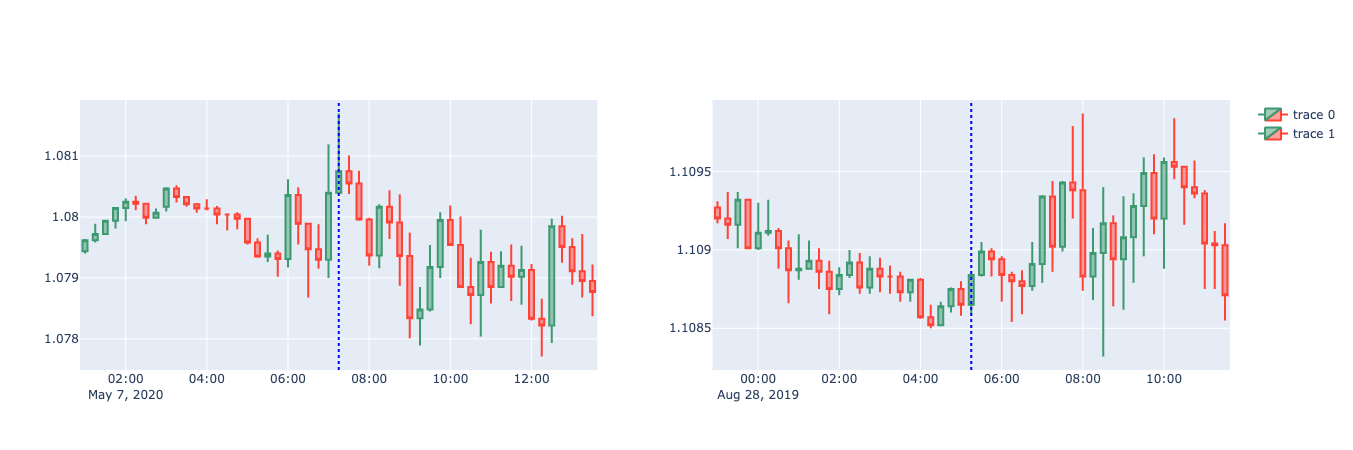

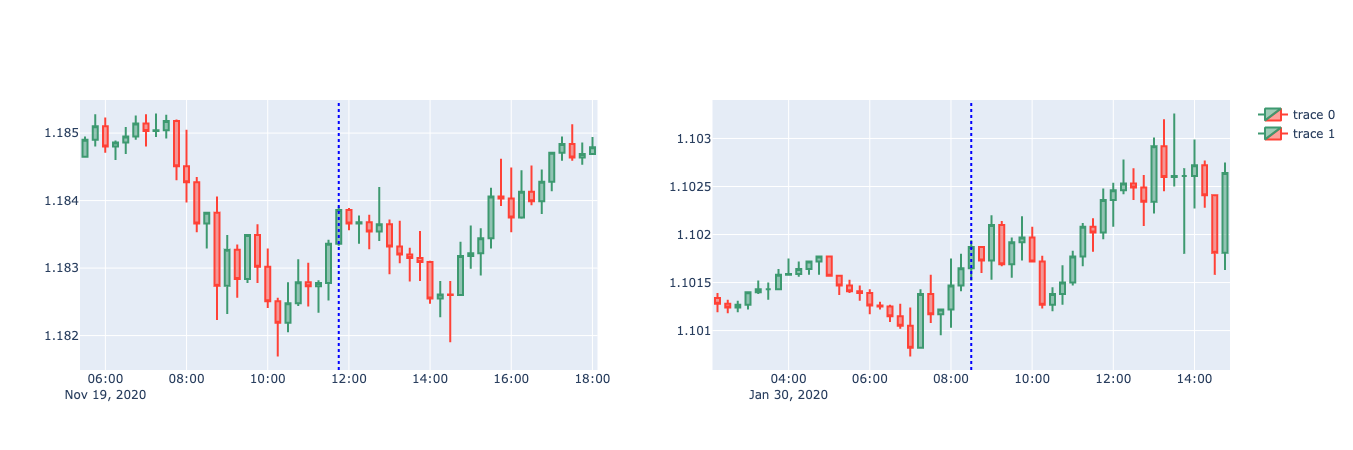

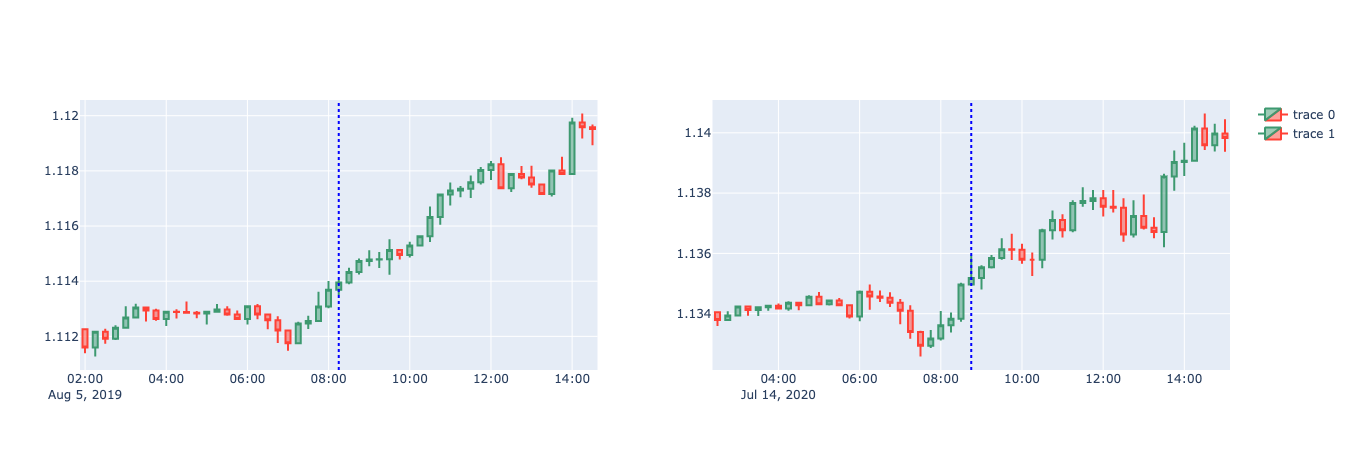

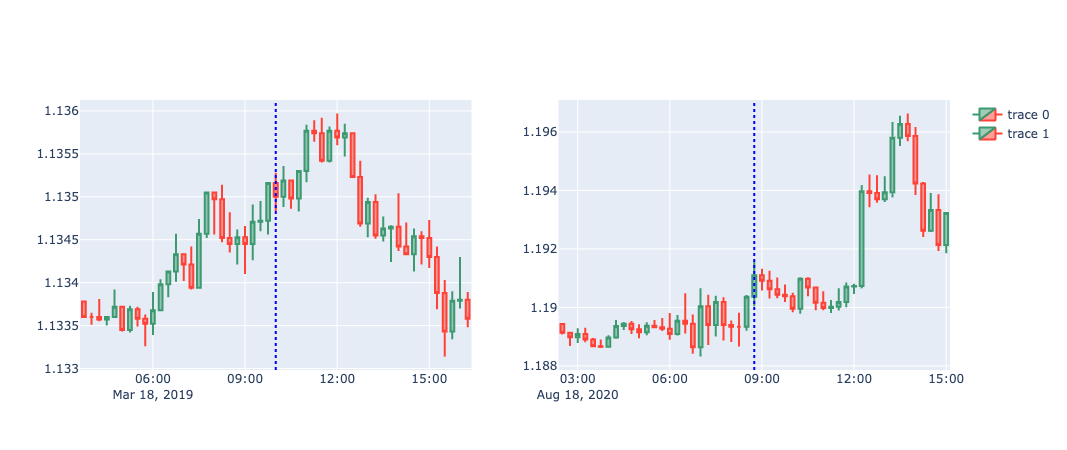

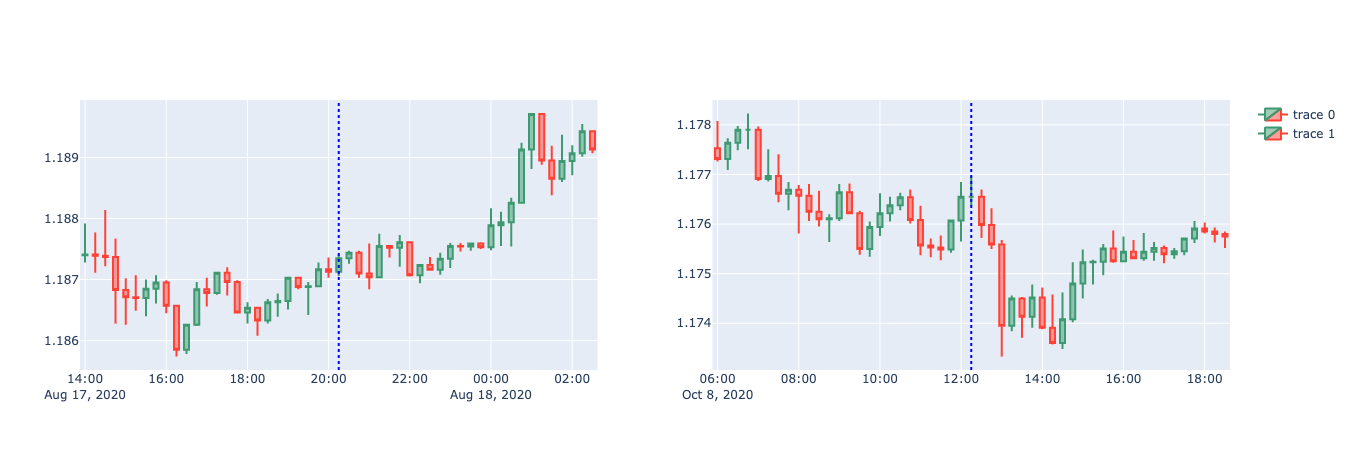

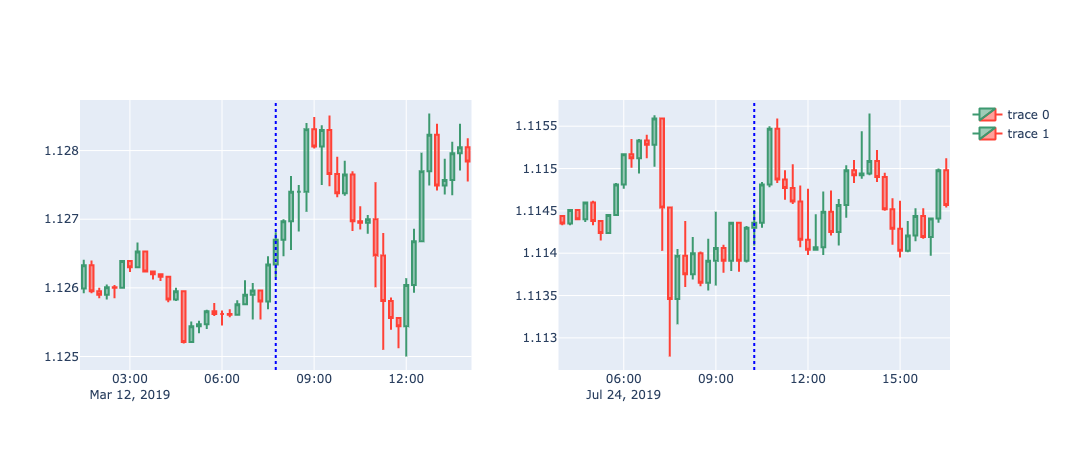

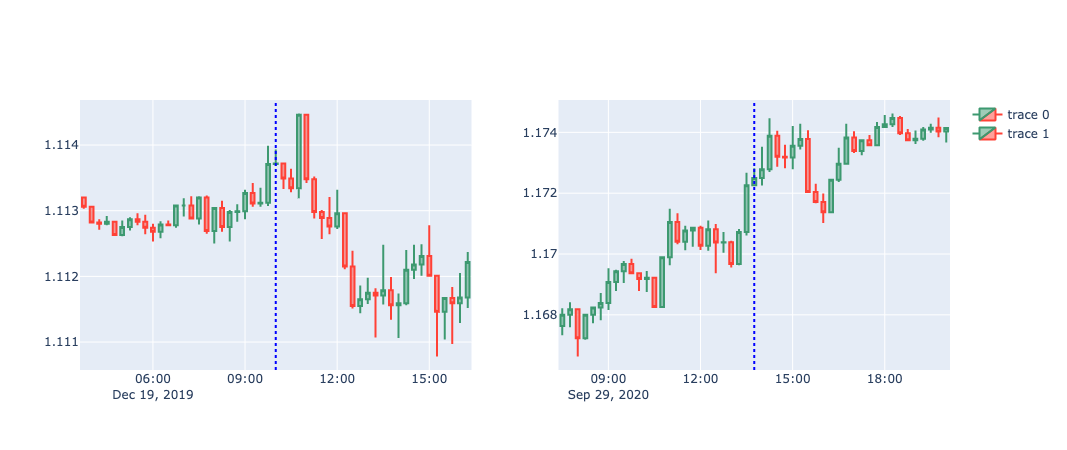

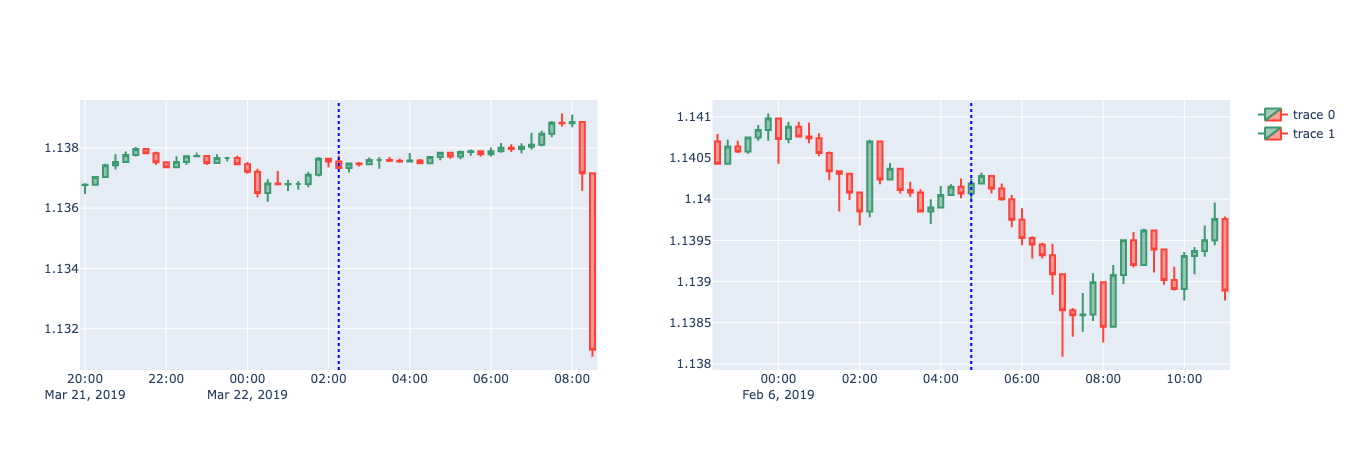

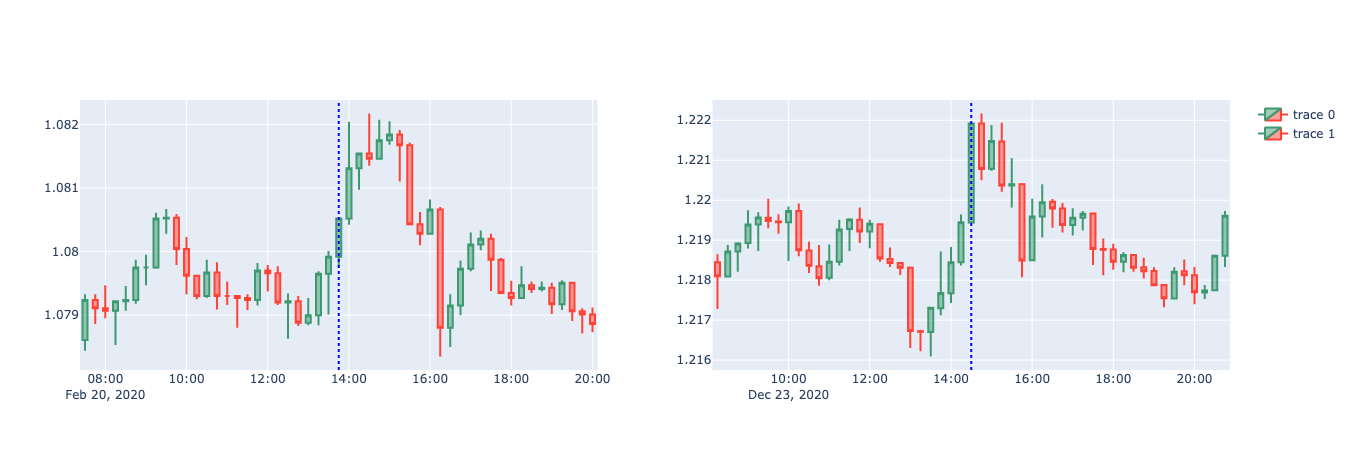

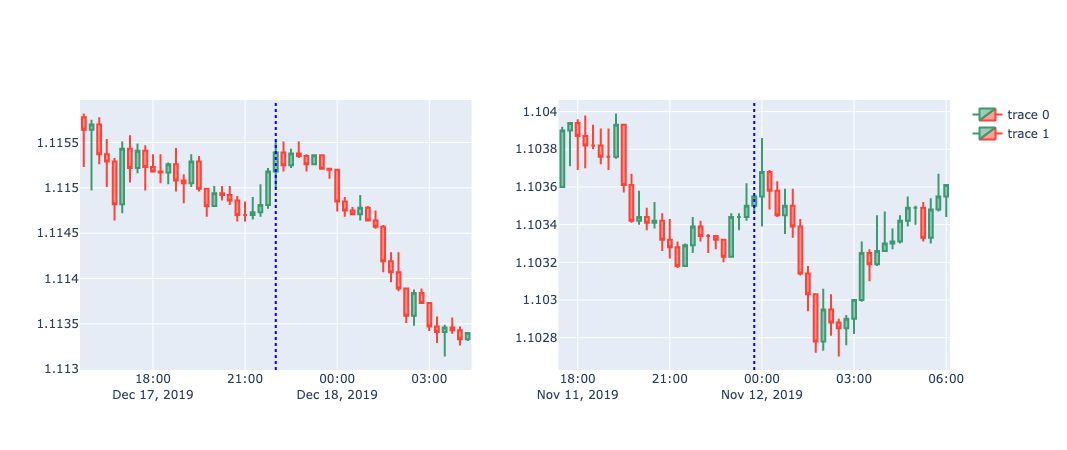

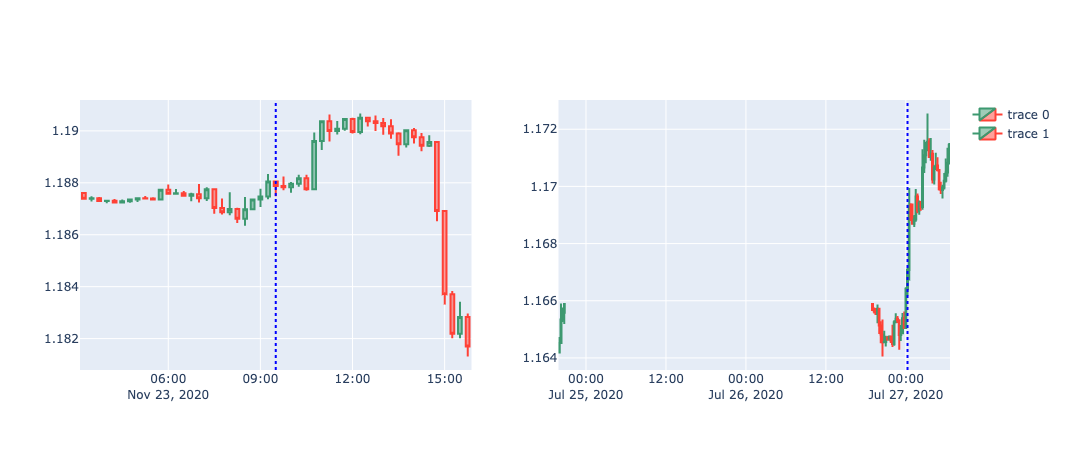

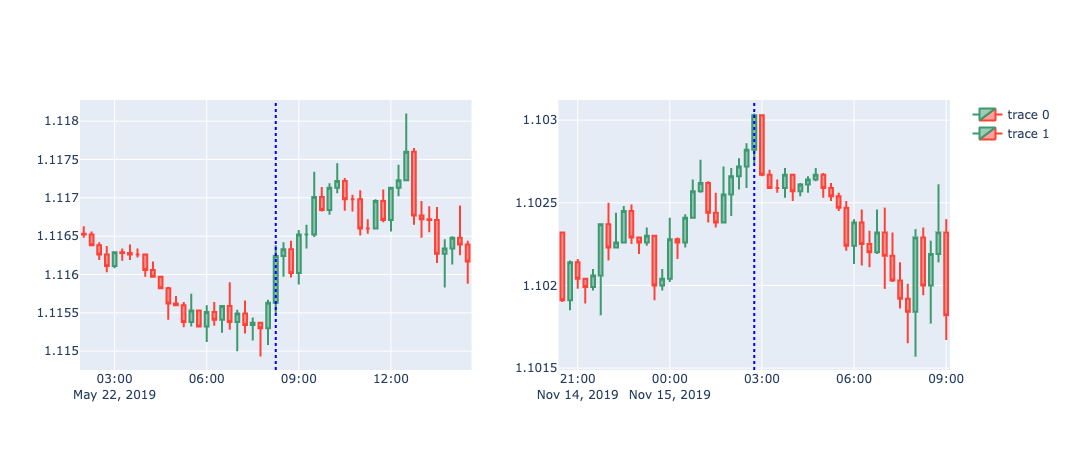

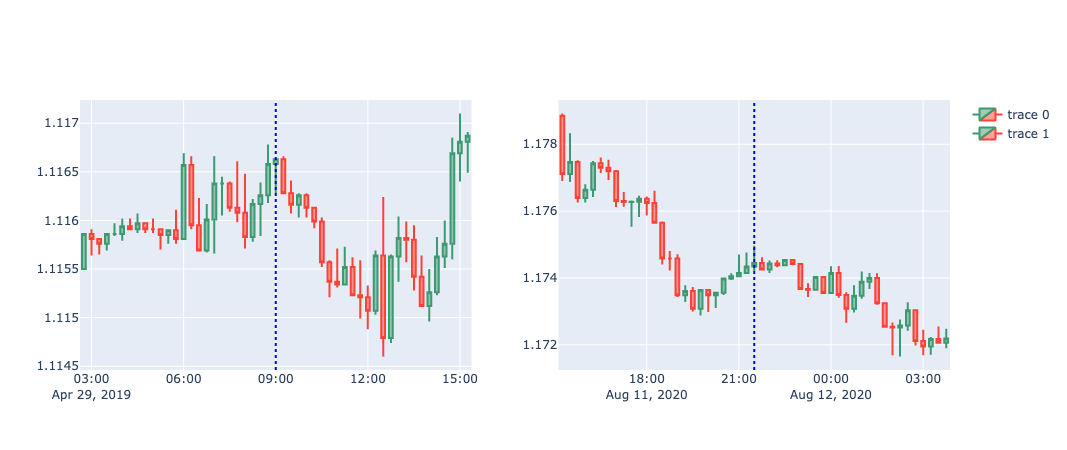

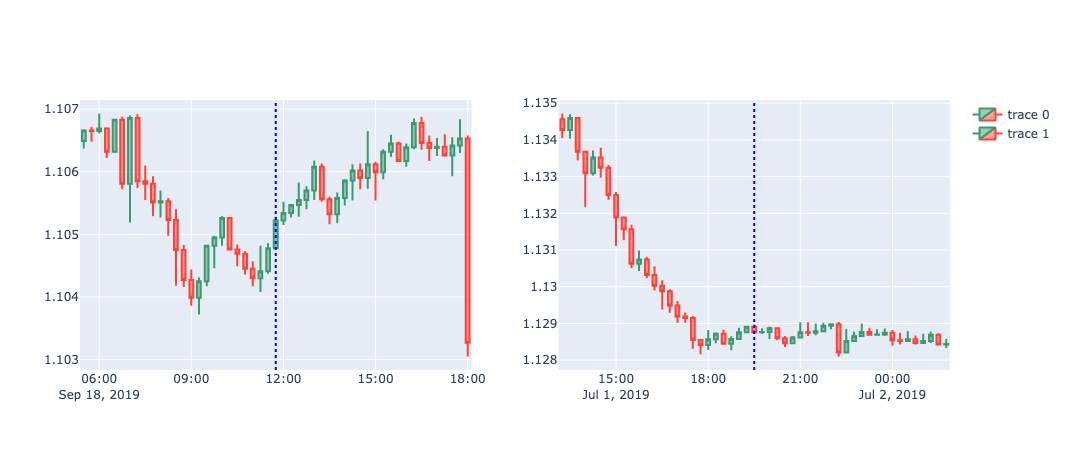

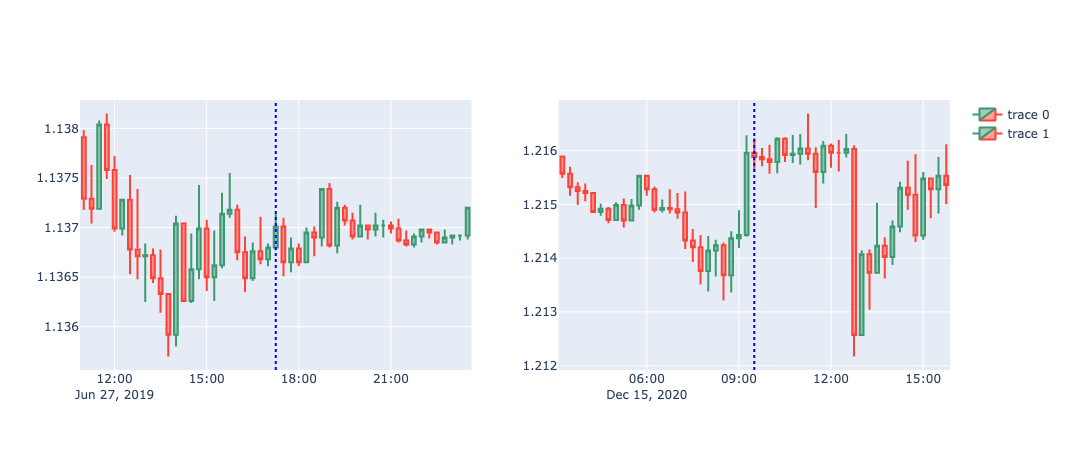

In [39]:
show_random_cases(candles_to_show, indicator_name)

In [8]:
candles_to_show.loc[(candles_to_show['date'] >= '2020-07-01 16:00:00') & (candles_to_show['date'] <= '2020-07-01 17:00:00'), ['date', 'close', 'slope']]

date    close      slope
188333 2020-07-01 16:00:00  1.12553   0.000000
188334 2020-07-01 16:05:00  1.12526   0.000000
188335 2020-07-01 16:10:00  1.12525   0.000000
188336 2020-07-01 16:15:00  1.12553   0.000000
188337 2020-07-01 16:20:00  1.12579   0.000000
188338 2020-07-01 16:25:00  1.12604   0.000000
188339 2020-07-01 16:30:00  1.12599  45.216755
188340 2020-07-01 16:35:00  1.12614   0.000000
188341 2020-07-01 16:40:00  1.12602   0.000000
188342 2020-07-01 16:45:00  1.12588 -24.044223
188343 2020-07-01 16:50:00  1.12614   0.000000
188344 2020-07-01 16:55:00  1.12649   0.000000
188345 2020-07-01 17:00:00  1.12659   0.000000

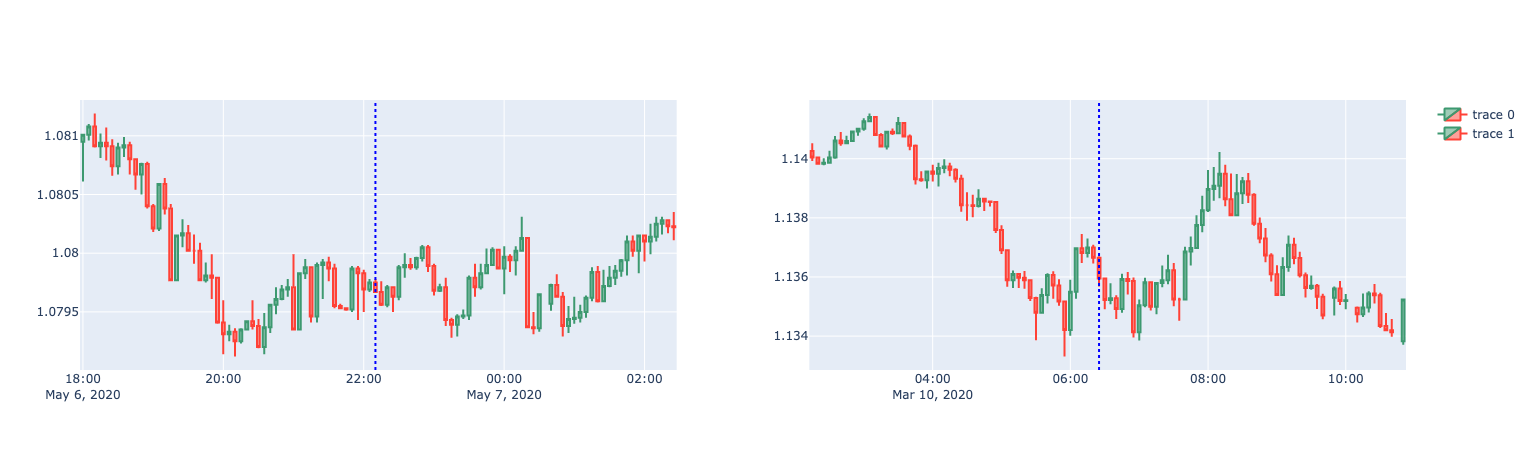

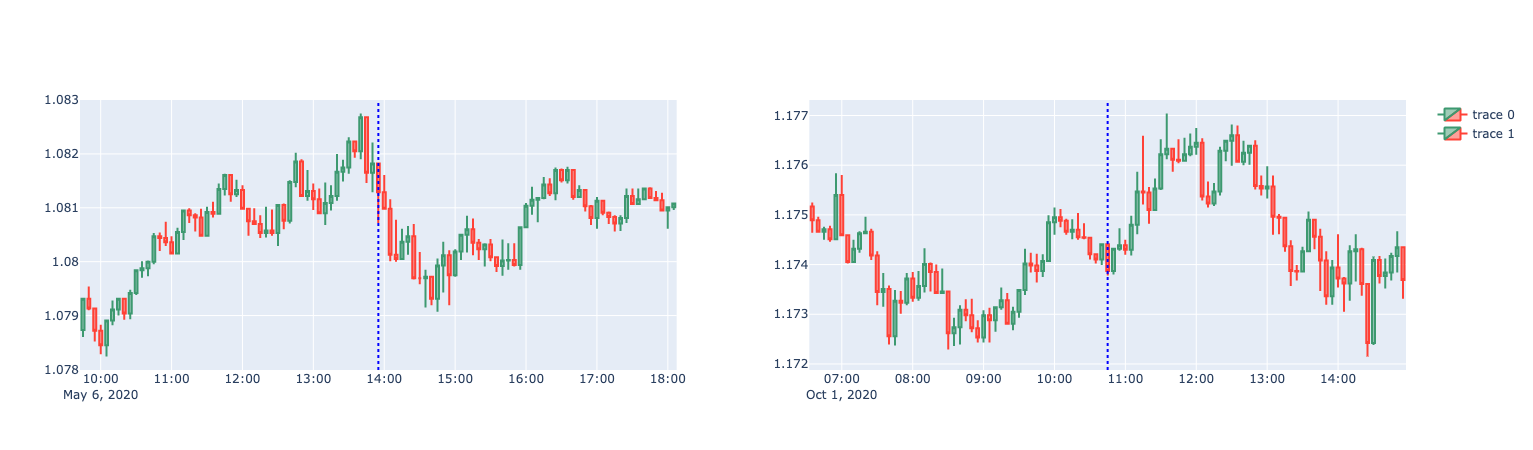

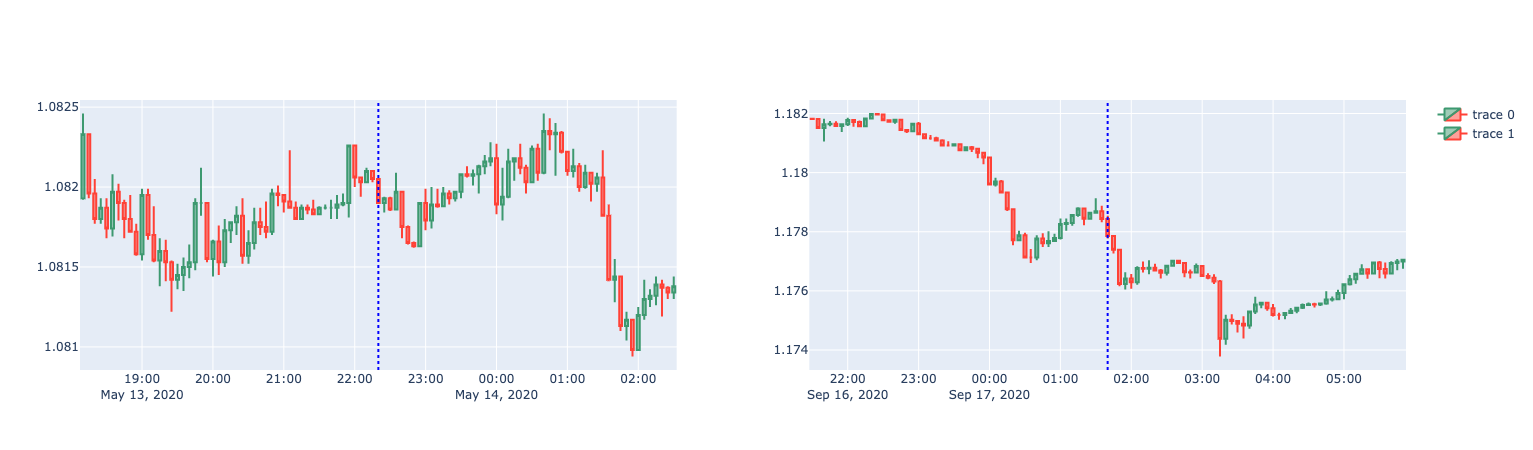

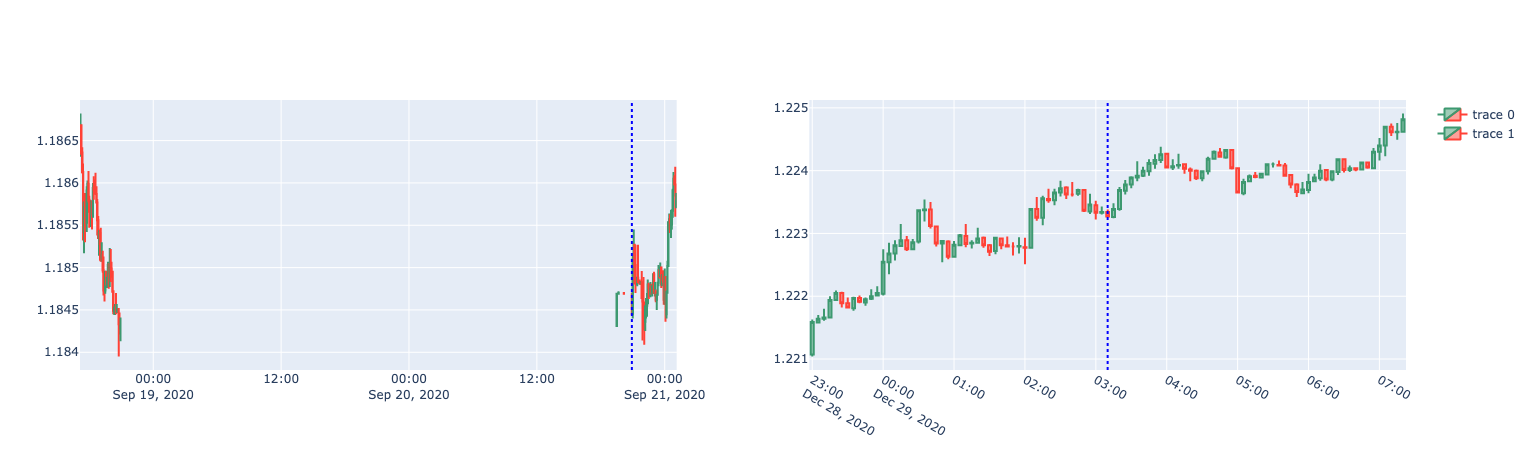

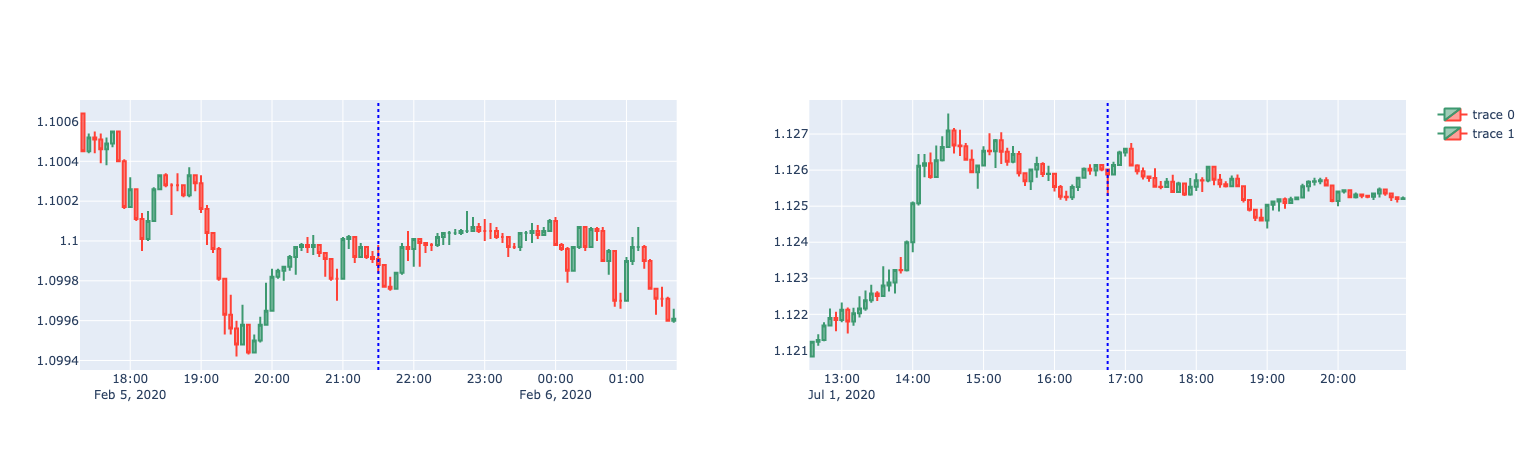

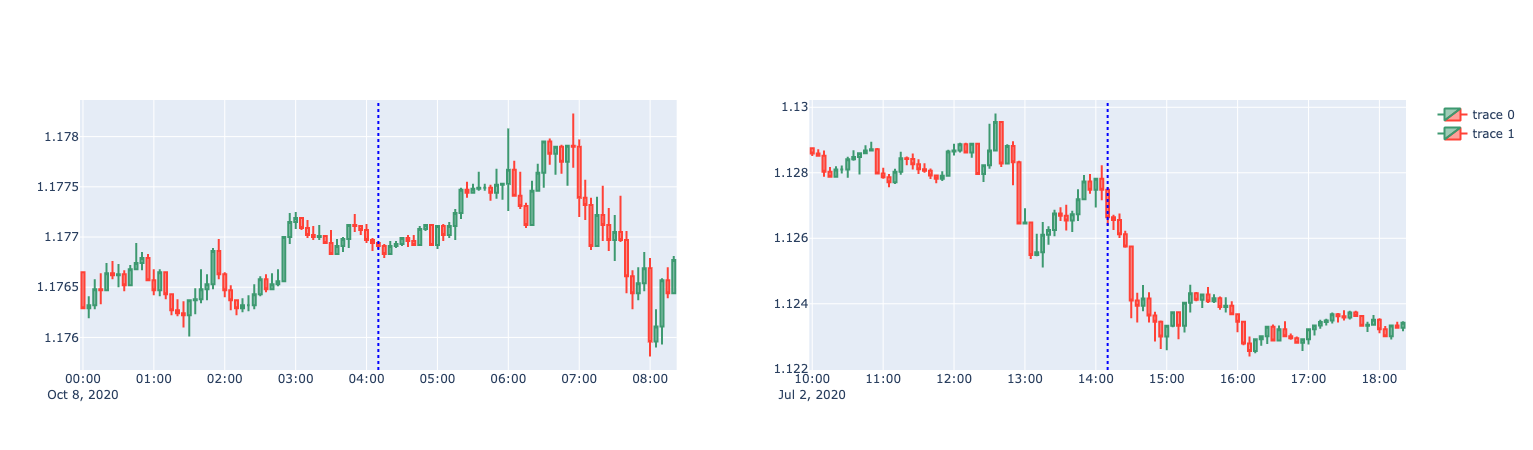

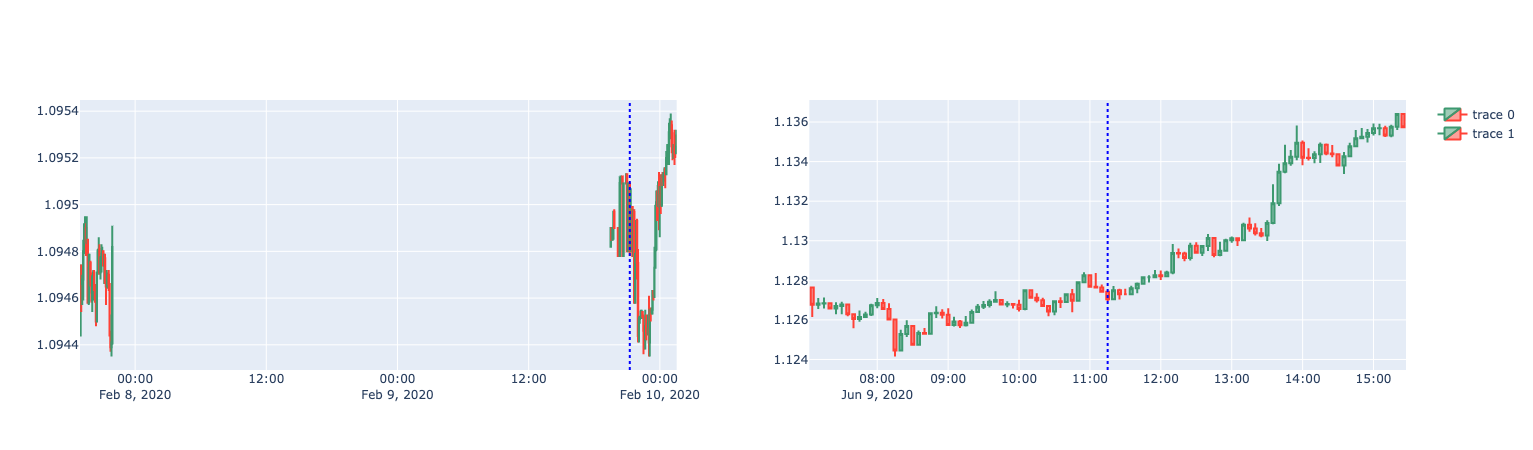

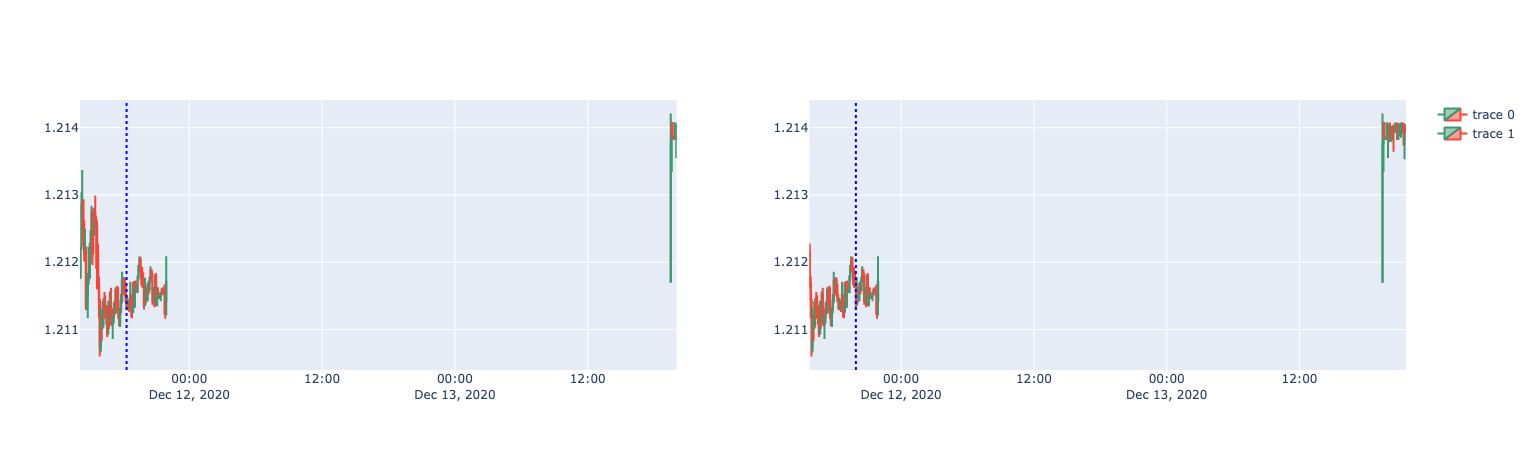

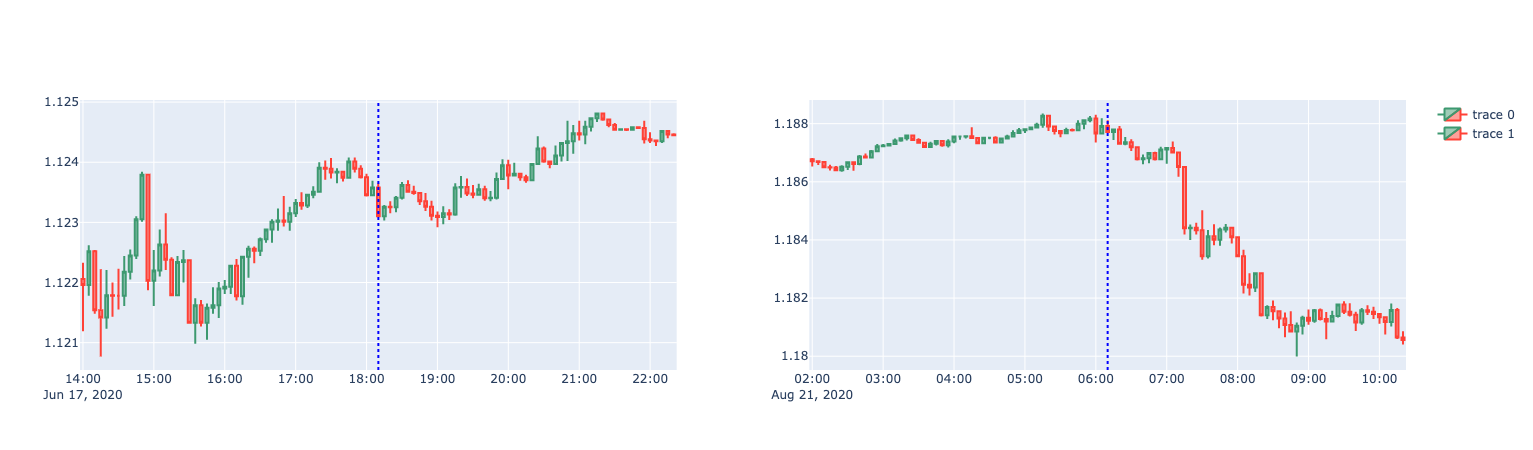

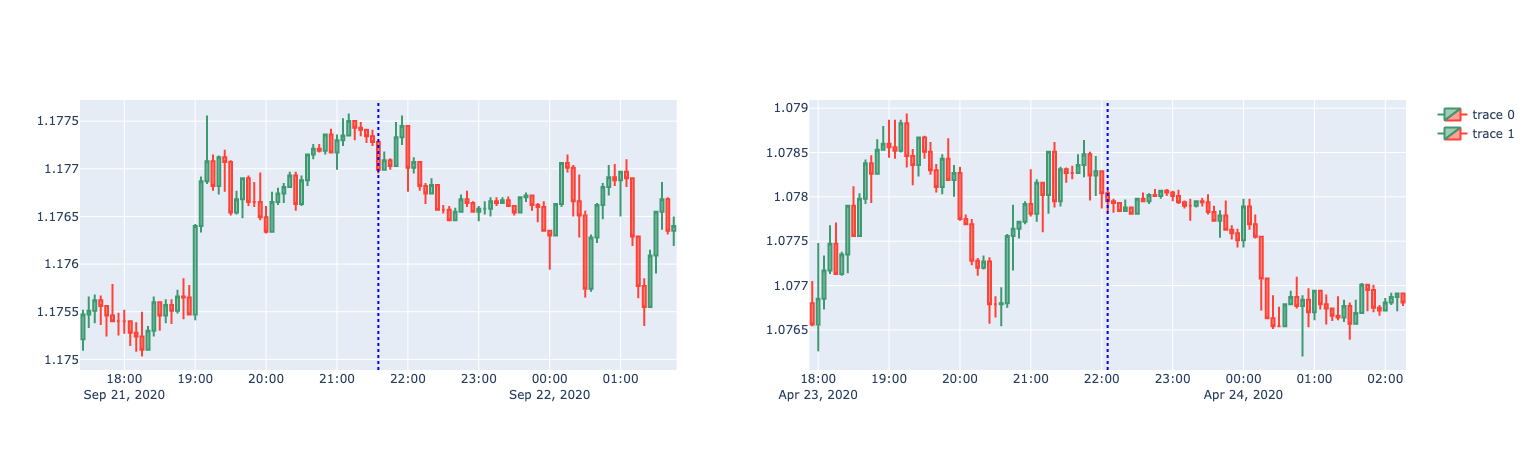

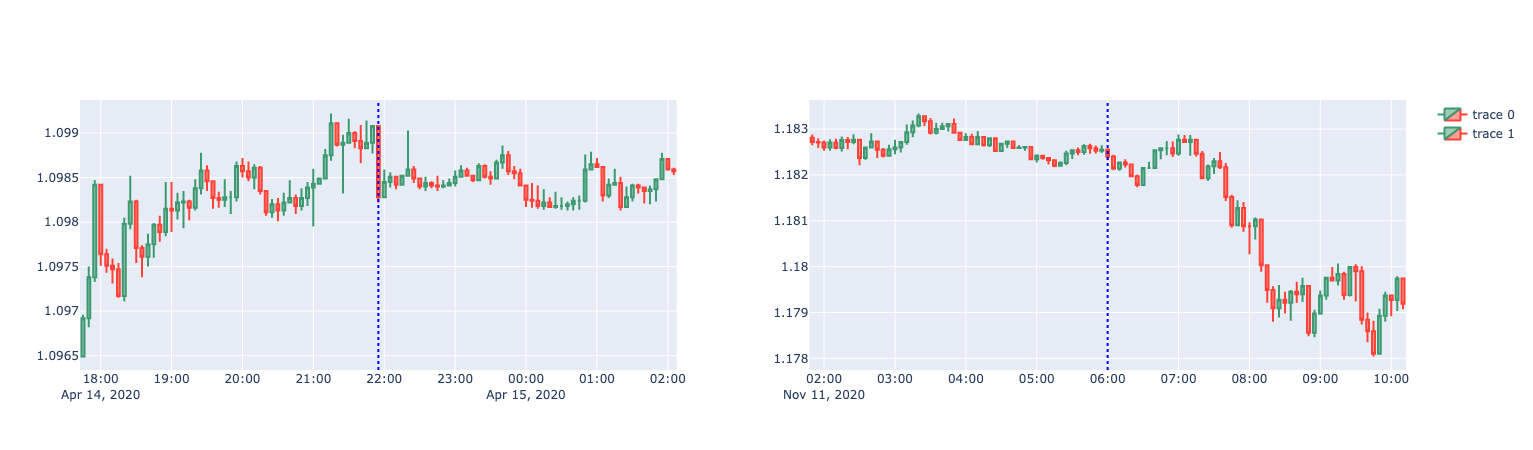

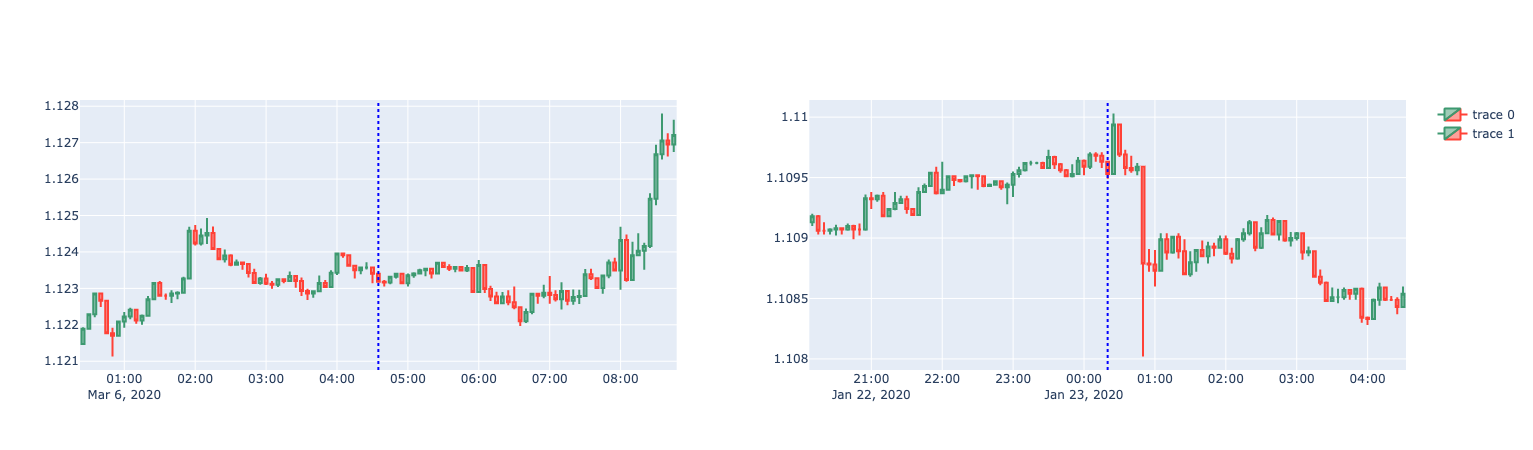

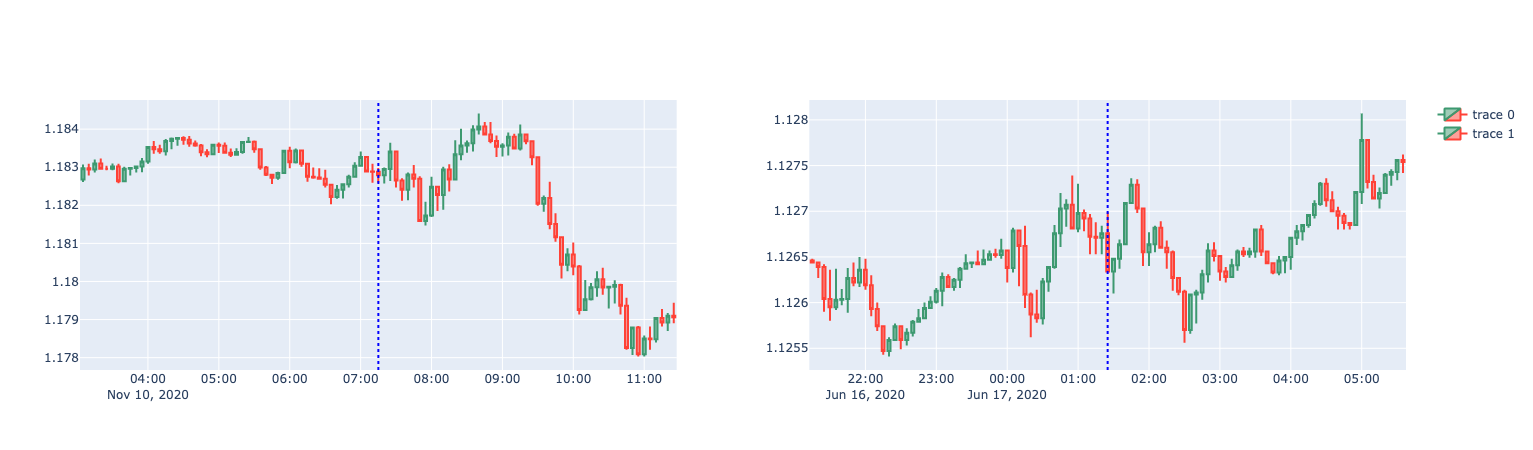

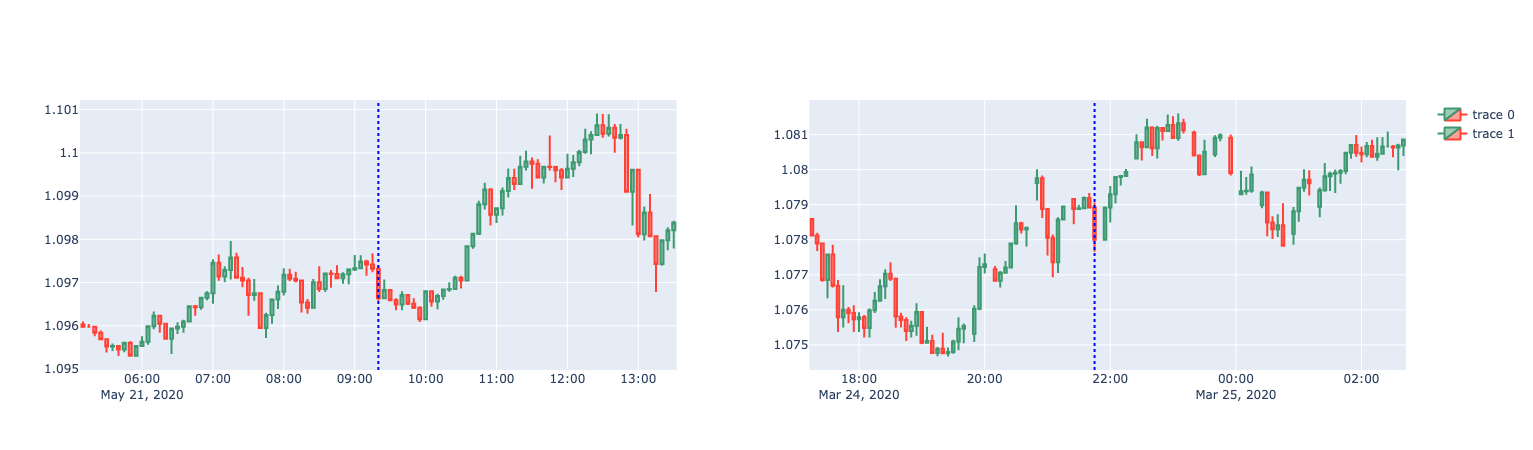

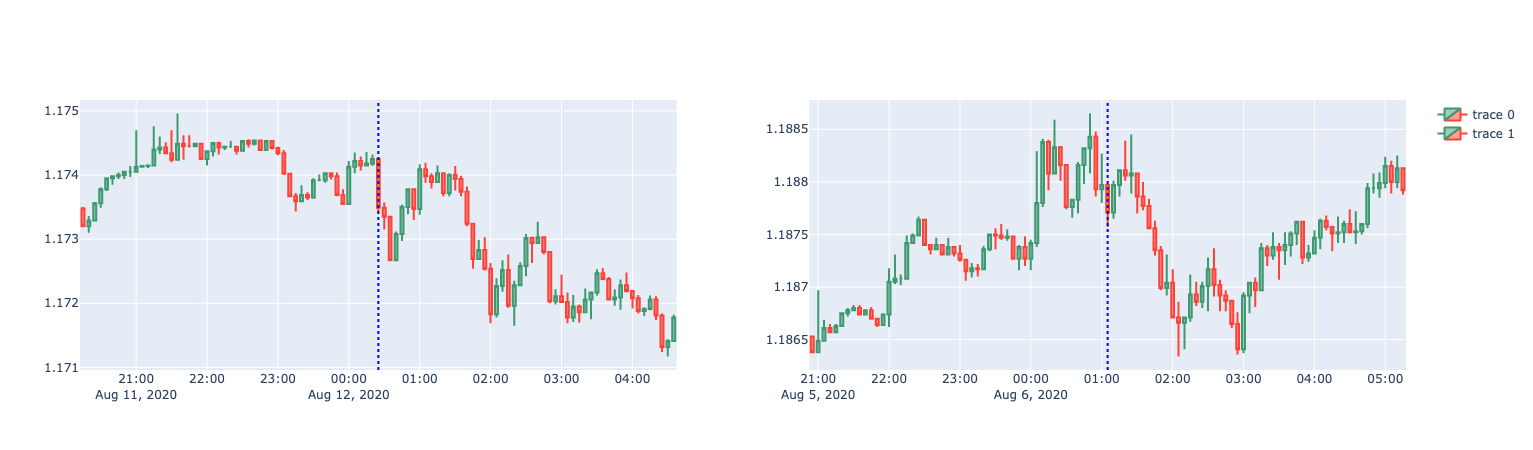

In [270]:
for i, (idx_start, idx_end) in enumerate(range_of_idx_to_show):
    data = candles_to_show.loc[idx_start: idx_end, :]
    idx = nb_candles_to_show // 2 + idx_start
    data_tmp = data.loc[idx, :]
    
    if i % 2 == 0:
        fig = make_subplots(rows=1, cols=2)
    fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)
    fig.update_yaxes(fixedrange=False)

    fig.add_trace(go.Candlestick(x=data['date'],
                                 open=data['open'],
                                 high=data['high'],
                                 low=data['low'],
                                 close=data['close']),
                  row=1, col= i % 2 + 1)
       
    fig.add_vline(x=data_tmp.date, line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)
    if i % 2 == 1:
        fig.show()